Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 23-September-2025

In [76]:
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# Set parameters and load data
data_dir = r'Z:/Data/Roadrunner/'
dataset = 'treadmill_rr_cschrimson_walking_initiation.csv'

if 'control' in dataset:
    optogenetics = False
    color = [0,0,0]
else:
    optogenetics = True
    color = [0/255, 174/255, 239/255]
    
sampling_rate = 300 # Hz
stimulus_duration = 1 # s
filter_size = 0.3 # s


# Load data
# Note: Positive angular velocity corresponds to clockwise (right) turning
df = pd.read_csv(data_dir+dataset) 
df

,animal_id,animal_sex,experiment,trial,frame,time,stimulus,resting,walking,grooming,...,other,forward_velocity,lateral_velocity,angular_velocity,swing_L1,swing_L2,swing_L3,swing_R1,swing_R2,swing_R3
0,3,female,2024-07-19_A08,1,1,0.000000,-10.000137,0,0,0,...,1,0.471975,-0.474479,-13.066642,0,0,0,0,0,0
1,3,female,2024-07-19_A08,1,2,0.003335,-9.999750,0,0,0,...,1,1.041226,-0.801795,-36.145065,0,0,0,0,0,0
2,3,female,2024-07-19_A08,1,3,0.006671,-10.000044,0,0,0,...,1,1.678328,-1.055074,-47.547762,0,0,0,0,0,0
3,3,female,2024-07-19_A08,1,4,0.010006,-10.000127,0,0,0,...,1,2.351481,-1.238709,-49.123931,0,0,0,0,0,0
4,3,female,2024-07-19_A08,1,5,0.013342,-9.999795,0,0,0,...,1,3.028885,-1.357089,-42.722769,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73495,16,male,2024-09-16_A07,8,1496,4.986458,-10.000040,1,0,0,...,0,-0.051200,-0.047894,2.439269,0,0,0,0,0,0
73496,16,male,2024-09-16_A07,8,1497,4.989794,-9.999809,1,0,0,...,0,-0.061315,-0.058111,2.953915,0,0,0,0,0,0
73497,16,male,2024-09-16_A07,8,1498,4.993129,-10.000147,1,0,0,...,0,-0.060461,-0.057519,2.789704,0,0,0,0,0,0
73498,16,male,2024-09-16_A07,8,1499,4.996465,-10.000083,1,0,0,...,0,-0.045023,-0.042530,1.810151,0,0,0,0,0,0


In [ ]:
# Compute latency between stimulus onset and swing onsets and likelihood of legs to swing first  
parameters = ['swing_L1','swing_L2','swing_L3','swing_R1','swing_R2','swing_R3']
wiggle_room = 1 # Frames
bin_width = 30 # Frames
bins = np.linspace(0,300,int(sampling_rate/bin_width)+1) # Frames

animal_ids = df.animal_id.unique().tolist()

latencies = np.zeros((len(animal_ids), len(parameters)))
latencies_sorted = np.zeros((len(animal_ids), len(parameters)))

swing_likelihoods = np.zeros((len(animal_ids), 3))
swing_likelihoods_T1 = np.zeros((len(animal_ids), len(bins)-1))
swing_likelihoods_T2 = np.zeros((len(animal_ids), len(bins)-1))
swing_likelihoods_T3 = np.zeros((len(animal_ids), len(bins)-1))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):

    # Initialize variables
    trials_animal = df.trial[df.animal_id == animal_id].unique().tolist()
    latencies_animal = np.zeros((len(trials_animal),len(parameters))) 
    latencies_sorted_animal = np.zeros((len(trials_animal),len(parameters))) 
    swing_likelihoods_animal = np.zeros(3) 
    
    print('Animal ' + str(animal_id) + ': ' + str(len(trials_animal)))

    # Loop over trials
    for trial_index, trial in enumerate(trials_animal):
        df_sub = df[(df.animal_id == animal_id) & (df.trial == trial)]
        
        # Find stimulus onset
        if optogenetics:
            stimulus = df_sub.stimulus.to_numpy()
        else:
            stimulus = df_sub.walking.to_numpy()
            
        stimulus_onset = np.argwhere(np.diff(stimulus) > 0.1) + 1 
        stimulus_onset = int(stimulus_onset[0][0])

        # Compute latencies to swing onsets 
        for parameter_index, parameter in enumerate(parameters):
            # Find first swing onset after stimulus
            swing = df_sub[parameter].to_numpy()
            swing_onsets = np.argwhere(np.diff(swing) > 0) + 1 
            first_swing_onset = int(swing_onsets[swing_onsets > stimulus_onset][0])

            # Compute time delay in ms
            latencies_animal[trial_index][parameter_index] = first_swing_onset - stimulus_onset # 1000 / sampling_rate * (first_swing_onset - stimulus_onset)

        # For spontaneous walking, subtract onset of first swing phase
        if not optogenetics:
            latencies_animal[trial_index][:] = latencies_animal[trial_index][:] - np.min(latencies_animal[trial_index][:])                

        # Determine whether a front, middle, or hind leg moved first
        min_latency = np.min(latencies_animal[trial_index][:])
        #first_leg_indices = np.where(latencies_animal[trial_index] == min_latency)[0]
        first_leg_indices = np.where(latencies_animal[trial_index] <= min_latency + wiggle_room)[0]
                
        # If multiple legs swing at the same time, first_leg_index will have multiple entries 
        if any(np.isin(first_leg_indices, np.array([0,3]))):
            swing_likelihoods_animal[0] += 1
        if any(np.isin(first_leg_indices, np.array([1,4]))):
            swing_likelihoods_animal[1] += 1
        if any(np.isin(first_leg_indices, np.array([2,5]))):
            swing_likelihoods_animal[2] += 1

    # Sort latencies in ascending order 
    latencies_sorted_animal = latencies_animal.copy()
    latencies_sorted_animal.sort()
        
    # Average latencies across trials
    latencies[animal_id_index] = np.mean(latencies_sorted_animal,axis=0)    

    # Compute swing likelihood across trials 
    swing_likelihoods[animal_id_index][:] = swing_likelihoods_animal / np.sum(swing_likelihoods_animal)

    # Compute the likelihood of a front, middle, or hind leg starting to swing as a function of time
    leg_pairs = [[0,3], [1,4], [2,5]]
    for leg_pair_index, leg_pair in enumerate(leg_pairs):
        counts, _ = np.histogram(np.min(latencies_animal[:][:,leg_pair],axis=1), bins = bins)
        counts = counts/np.sum(counts)
        if leg_pair_index == 0:
            swing_likelihoods_T1[animal_id_index] = counts
        elif leg_pair_index == 1:
            swing_likelihoods_T2[animal_id_index] = counts
        else:
            swing_likelihoods_T3[animal_id_index] = counts

Animal 3: 7
Animal 4: 3
Animal 5: 5
Animal 6: 4
Animal 8: 3
Animal 10: 8
Animal 13: 5
Animal 15: 6
Animal 16: 8


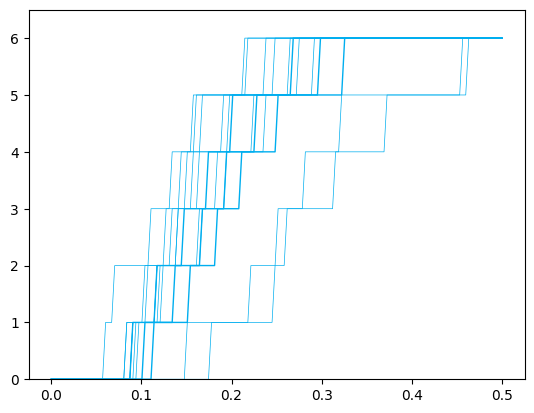

In [79]:
# Plot latencies
duration = 0.5
data_to_plot = np.zeros((len(animal_ids), int(duration*sampling_rate)))
time = np.linspace(0, 1/sampling_rate * (duration*sampling_rate), int(duration*sampling_rate))

for animal_id_index, _ in enumerate(animal_ids):
    for onset in latencies[animal_id_index]: 
        data_to_plot[animal_id_index][int(onset):] += 1
    
    plt.plot(time, data_to_plot[animal_id_index], color=color, linewidth=0.5) 

# Compute mean of means
mean_latencies = np.round(np.mean(latencies,axis=0))
mean_data_to_plot = np.zeros((1, int(duration*sampling_rate)))
for onset in mean_latencies: 
    mean_data_to_plot[0][int(onset):] += 1

# Compute sem of means
sem_latencies = np.std(latencies,axis=0) / np.sqrt(len(animal_ids))
lower_sem = mean_latencies-sem_latencies
upper_sem = mean_latencies+sem_latencies
lower_sem_data_to_plot = np.zeros((1, int(duration*sampling_rate)))
upper_sem_data_to_plot = np.zeros((1, int(duration*sampling_rate)))
for onset in lower_sem: 
    lower_sem_data_to_plot[0][int(onset):] += 1
for onset in upper_sem: 
    upper_sem_data_to_plot[0][int(onset):] += 1
    
plt.plot(time, mean_data_to_plot[0], color=color, linewidth=1)
plt.plot(time, lower_sem_data_to_plot[0], color=color, linewidth=1)
plt.plot(time, upper_sem_data_to_plot[0], color=color, linewidth=1)
plt.ylim([0,6.5])
#plt.savefig(r'C:/Users/Chris/Desktop/figure.eps')
plt.show()

In [80]:
int((np.argwhere(mean_data_to_plot[0] == 6)[0][0] - np.argwhere(mean_data_to_plot[0] == 1)[0][0]) * 1000/sampling_rate)

193

In [81]:
## Plot mean latency of individual animal
#data_to_plot = np.zeros((stimulus_duration*sampling_rate))
#time = np.linspace(0, 1/sampling_rate * (stimulus_duration*sampling_rate), stimulus_duration*sampling_rate)
#
#animal_id_index = 2
#for onset in latencies[animal_id_index]: 
#    data_to_plot[int(onset):] += 1
#
#color = np.array([0,0,0]) + 0.1*speeds[animal_id_index]
#plt.plot(time, data_to_plot, color=color_rr) 
#plt.show()

In [82]:
# Display mean latency +- sem to first swing in ms
print(str(round(int(mean_latencies[0]) * 1000/sampling_rate)) + ' +- ' + str(round(int(sem_latencies[0]) * 1000/sampling_rate))) 

103 +- 10


In [83]:
# Display mean latency +- sem to last swing in ms
print(str(round(int(mean_latencies[5]) * 1000/sampling_rate)) + ' +- ' + str(round(int(sem_latencies[5]) * 1000/sampling_rate))) 

297 +- 27


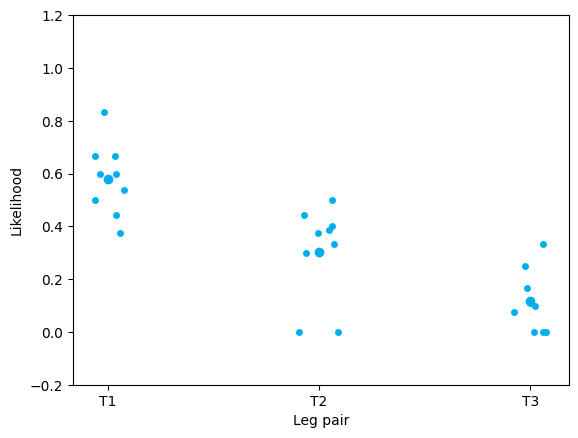

In [84]:
# Plot likelihood of legs to swing first
sns.stripplot(swing_likelihoods, color=color)
plt.plot(np.mean(swing_likelihoods, axis=0), 'o', color=color)
plt.ylim([-0.2,1.2])
plt.xlabel('Leg pair')
plt.ylabel('Likelihood')
ax = plt.gca()
ax.set_xticks(ticks=[0,1,2], labels=['T1','T2','T3'])
#plt.savefig(r'C:/Users/Chris/Desktop/figure.eps')
plt.show()